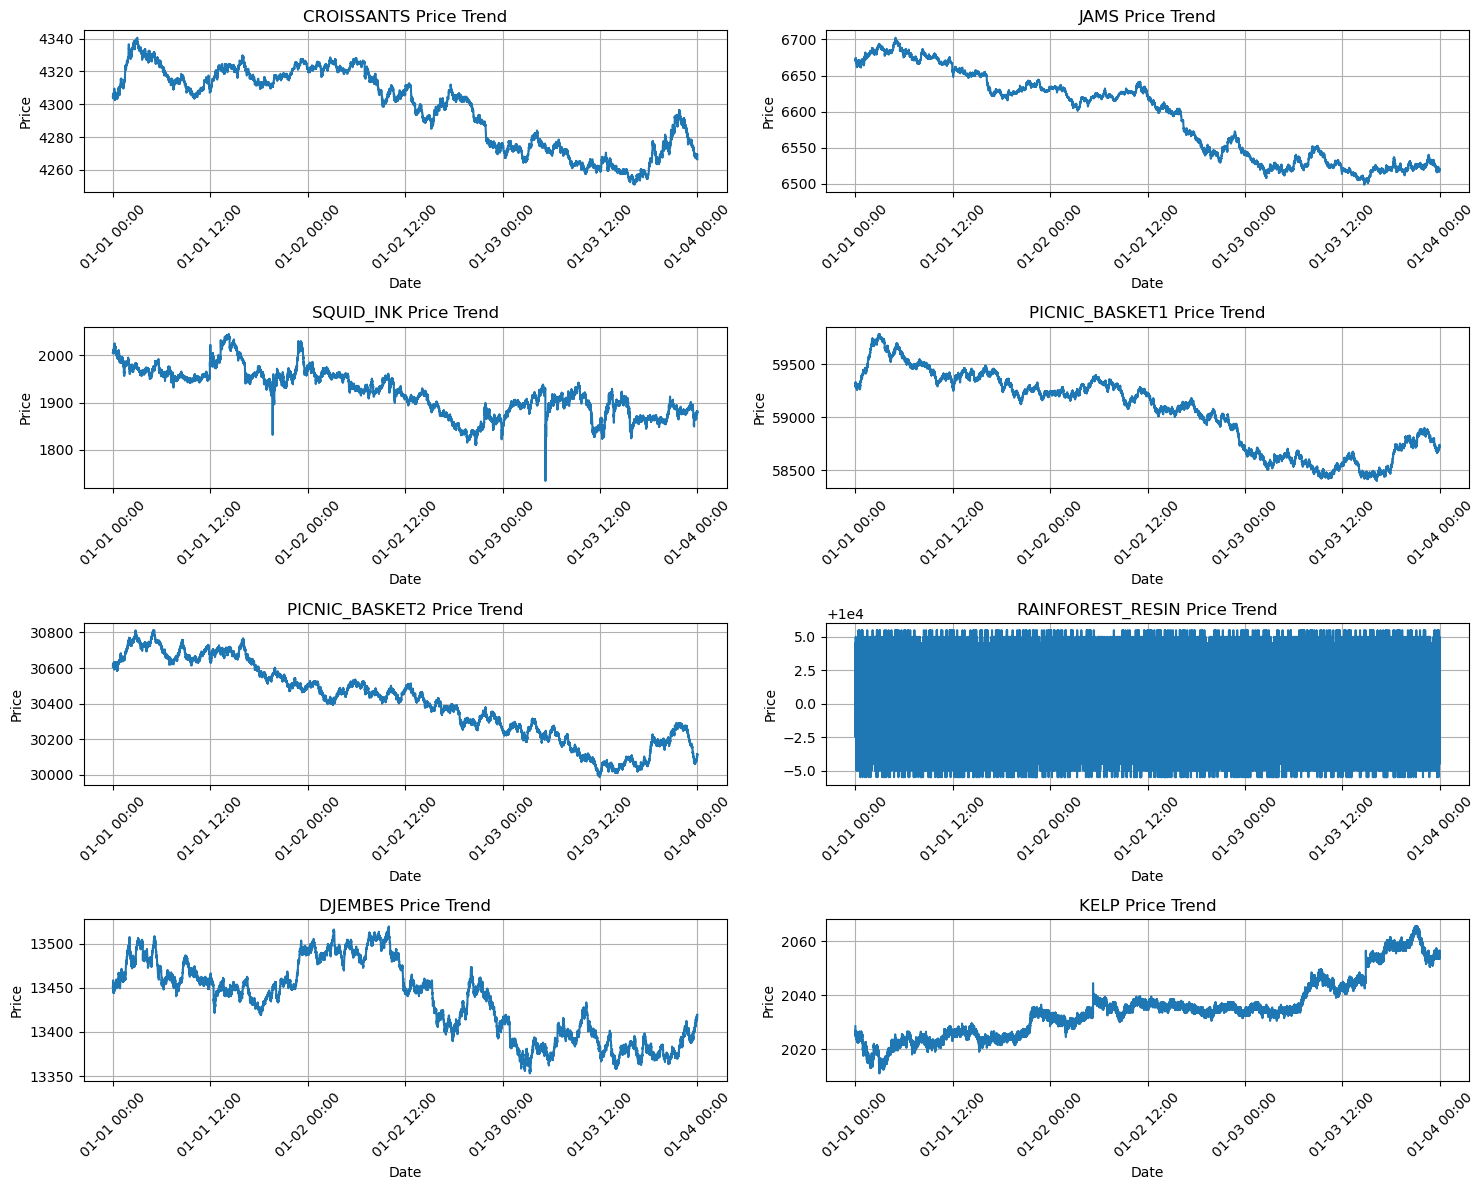

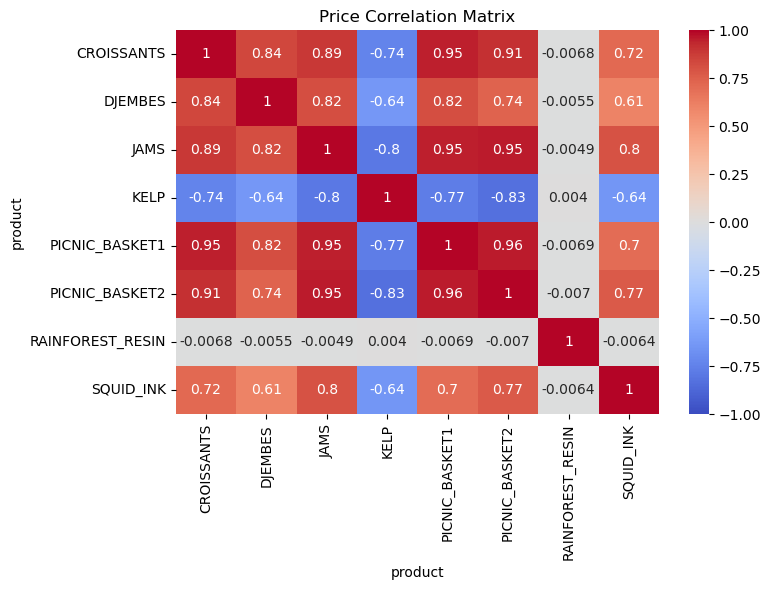


Product Statistics:
                 mid_price                                 
                      mean     std      min      max  count
product                                                    
CROISSANTS         4297.84   23.78   4251.0   4340.5  30000
DJEMBES           13436.23   42.95  13353.0  13519.5  30000
JAMS               6593.32   59.55   6498.5   6702.5  30000
KELP               2034.94   10.94   2011.0   2065.5  30000
PICNIC_BASKET1    59051.99  363.67  58397.5  59786.5  30000
PICNIC_BASKET2    30408.23  214.97  29987.5  30813.0  30000
RAINFOREST_RESIN  10000.01    2.20   9994.5  10005.5  30000
SQUID_INK          1922.24   48.01   1734.5   2045.5  30000

Correlation Matrix:
product           CROISSANTS  DJEMBES   JAMS   KELP  PICNIC_BASKET1  \
product                                                               
CROISSANTS             1.000    0.840  0.885 -0.735           0.950   
DJEMBES                0.840    1.000  0.820 -0.635           0.819   
JAMS          

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("/Users/yibaozhang/Downloads/round-2-island-data-bottle/merged.csv", sep=';')

# Convert to proper datetime with correct timestamp handling
df['date'] = pd.to_datetime('2024-01-02') + pd.to_timedelta(df['day'], unit='D') + pd.to_timedelta(df['timestamp'] * (24*3600/1e6), unit='s')

# Group by product and calculate statistics
product_stats = df.groupby('product').agg({
    'mid_price': ['mean', 'std', 'min', 'max', 'count']
}).round(2)

# Create pivot table for correlation analysis
prices_pivot = df.pivot_table(index='date', columns='product', values='mid_price')

# Calculate correlation matrix
correlation_matrix = prices_pivot.corr()

# Plotting
# Get unique products and calculate subplot layout
products = df['product'].unique()
n_products = len(products)

# Create two separate figures: one for prices, one for correlation
# Price trends figure
fig_prices = plt.figure(figsize=(15, 3*((n_products+1)//2)))
for idx, product in enumerate(products, 1):
    ax = fig_prices.add_subplot((n_products+1)//2, 2, idx)
    product_data = df[df['product'] == product]
    ax.plot(product_data['date'], product_data['mid_price'])
    ax.set_title(f'{product} Price Trend')
    ax.set_xlabel('Date')
    ax.set_ylabel('Price')
    plt.setp(ax.get_xticklabels(), rotation=45)
    ax.grid(True)
    # Format date ticks
    ax.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%m-%d %H:%M'))
    ax.xaxis.set_major_locator(plt.matplotlib.dates.AutoDateLocator())

fig_prices.tight_layout()
plt.show()

# Correlation heatmap in a separate figure
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Price Correlation Matrix')
plt.tight_layout()
plt.show()

# Print statistics
print("\nProduct Statistics:")
print(product_stats)
print("\nCorrelation Matrix:")
print(correlation_matrix.round(3))



In [9]:
#before trading: we should do some technique for denoise
# Add required imports
from scipy.signal import savgol_filter
from statsmodels.nonparametric.smoothers_lowess import lowess
import pywt
from sklearn.decomposition import PCA
from pykalman import KalmanFilter

def analyze_denoising_methods(df, products):
    # Dictionary to store results
    denoising_results = {}
    
    for product in products:
        product_data = df[df['product'] == product]['mid_price'].values
        
        # 1. Simple Moving Average (SMA)
        window_size = 10
        sma = pd.Series(product_data).rolling(window=window_size, center=False).mean()
        
        # 2. Exponential Moving Average (EMA)
        alpha = 0.1
        ema = pd.Series(product_data).ewm(alpha=alpha, adjust=False).mean()
        
        # 3. Kalman Filter
        kf = KalmanFilter(
            initial_state_mean=product_data[0],
            n_dim_obs=1,
            n_dim_state=1,
            random_state=0
        )
        kalman_smoothed = kf.em(product_data).smooth(product_data)[0].flatten()
        
        # 4. LOWESS
        x = np.arange(len(product_data))
        lowess_smoothed = lowess(
            product_data, 
            x,
            frac=0.02,  # Adjust this parameter for smoothing strength
            return_sorted=False
        )
        
        # 5. Wavelet Denoising
        wavelet = 'db4'
        level = 3
        coeffs = pywt.wavedec(product_data, wavelet, level=level)
        threshold = np.std(coeffs[-1]) * np.sqrt(2*np.log(len(product_data)))
        coeffs = [pywt.threshold(c, threshold, mode='soft') for c in coeffs]
        wavelet_smoothed = pywt.waverec(coeffs, wavelet)
        
        # Store results
        denoising_results[product] = {
            'original': product_data,
            'sma': sma,
            'ema': ema,
            'kalman': kalman_smoothed,
            'lowess': lowess_smoothed,
            'wavelet': wavelet_smoothed
        }
    
    # Plot results
    plt.figure(figsize=(20, 4*len(products)))
    
    for idx, (product, results) in enumerate(denoising_results.items(), 1):
        plt.subplot(len(products), 1, idx)
        
        # Plot original and denoised data
        plt.plot(results['original'], label='Original', alpha=0.5, color='gray')
        plt.plot(results['sma'], label='SMA', linewidth=2)
        plt.plot(results['ema'], label='EMA', linewidth=2)
        plt.plot(results['kalman'], label='Kalman', linewidth=2)
        plt.plot(results['lowess'], label='LOWESS', linewidth=2)
        plt.plot(results['wavelet'], label='Wavelet', linewidth=2)
        
        plt.title(f'Denoising Comparison for {product}')
        plt.xlabel('Time')
        plt.ylabel('Price')
        plt.legend()
        plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # Calculate noise reduction metrics
    noise_metrics = {}
    for product, results in denoising_results.items():
        original = results['original']
        metrics = {}
        for method, denoised in results.items():
            if method != 'original':
                # Calculate RMSE
                rmse = np.sqrt(np.mean((original - denoised)**2))
                # Calculate noise reduction percentage
                noise_reduction = (1 - rmse/np.std(original)) * 100
                metrics[method] = noise_reduction
        noise_metrics[product] = metrics
    
    # Plot noise reduction metrics
    metrics_df = pd.DataFrame(noise_metrics).T
    
    plt.figure(figsize=(12, 6))
    metrics_df.plot(kind='bar')
    plt.title('Noise Reduction Percentage by Method')
    plt.xlabel('Product')
    plt.ylabel('Noise Reduction (%)')
    plt.legend(title='Method')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    return denoising_results, noise_metrics

# Run the analysis
denoising_results, noise_metrics = analyze_denoising_methods(df, products)

# Print summary statistics
print("\nNoise Reduction Summary:")
metrics_df = pd.DataFrame(noise_metrics).T
print(metrics_df.mean().round(2))

ModuleNotFoundError: No module named 'pykalman'

we notice that some products in round two have significant correlation, and this makes pair trading spread or pair trading possible
now let's calculate their spread

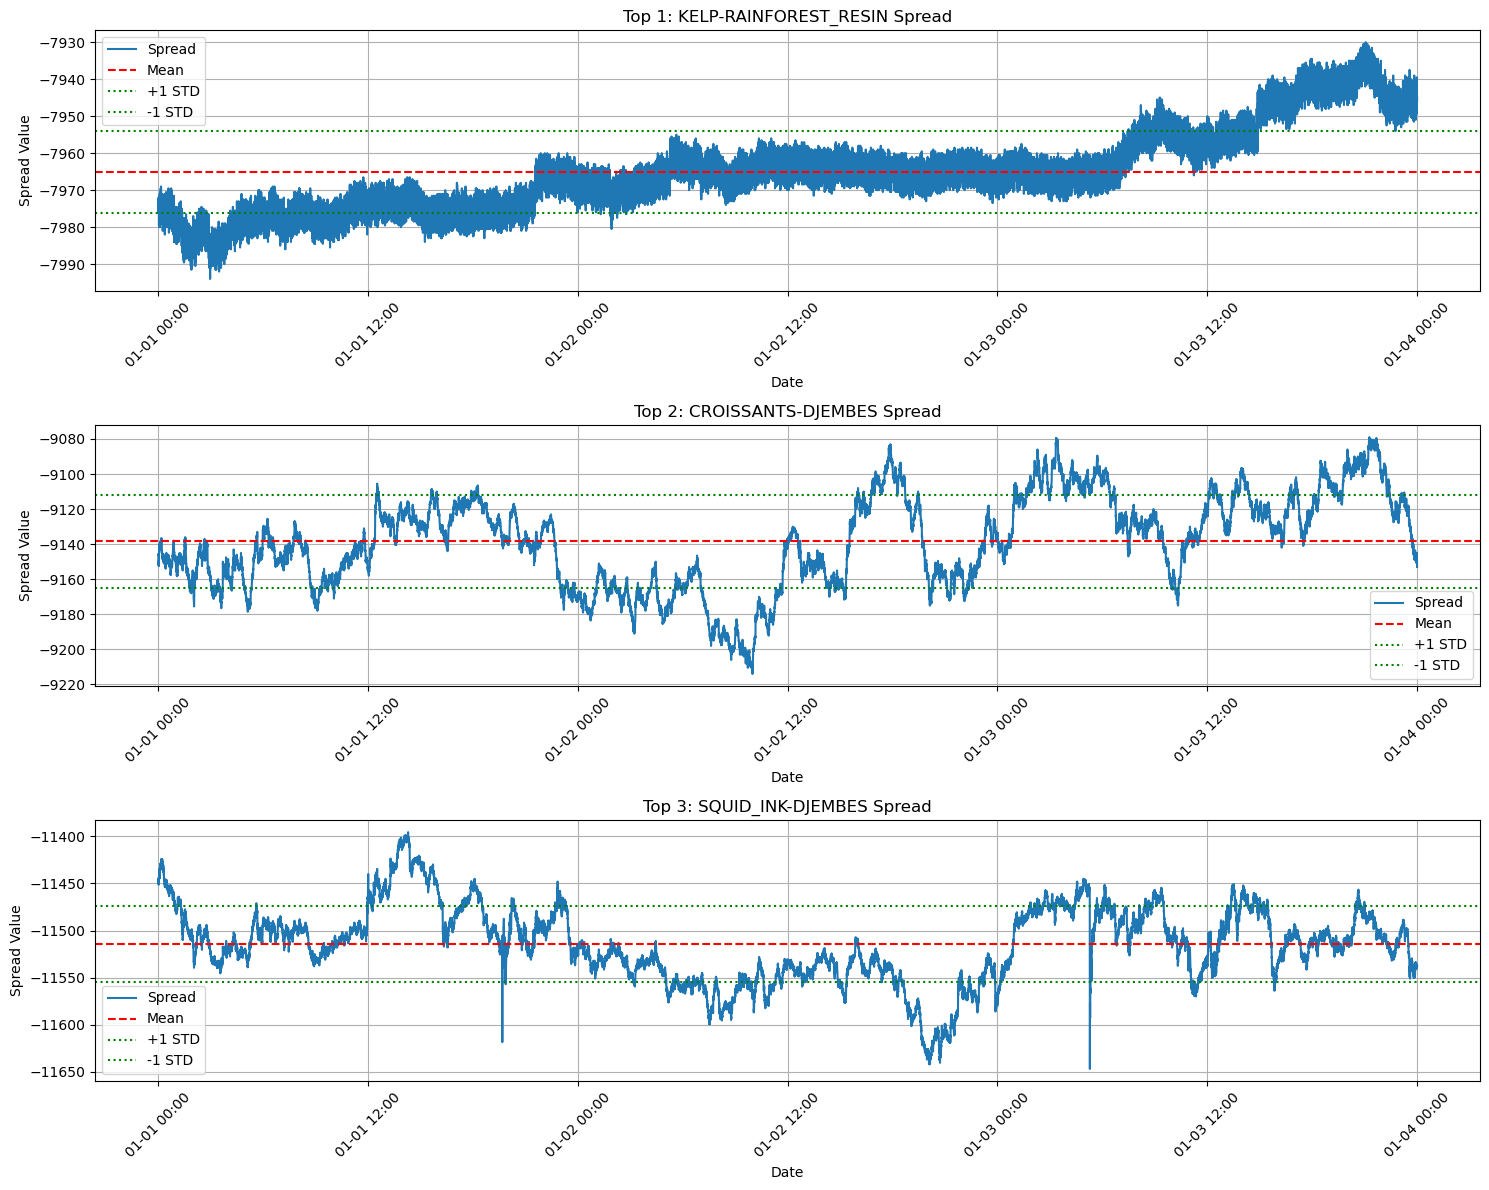


Top 3 Pairs for Statistical Arbitrage:

Pair Rankings (Overall Score):
                            mean     std   sharpe  mean_reversion  half_life  \
KELP-RAINFOREST_RESIN  -7965.067  11.151  714.276          -0.959     16.812   
CROISSANTS-DJEMBES     -9138.390  26.337  346.974          -0.999   1139.758   
SQUID_INK-DJEMBES     -11513.994  40.484  284.411          -0.999    512.429   

                       overall_score  
KELP-RAINFOREST_RESIN     285.440544  
CROISSANTS-DJEMBES        138.490163  
SQUID_INK-DJEMBES         113.465285  

Correlation between KELP and RAINFOREST_RESIN: 0.004

Correlation between CROISSANTS and DJEMBES: 0.840

Correlation between SQUID_INK and DJEMBES: 0.609


In [8]:
# Calculate all possible pairs and their spreads
products = df['product'].unique()
pairs = []
spread_data = {}

# Calculate spreads for all possible pairs
for i in range(len(products)):
    for j in range(i+1, len(products)):
        prod1, prod2 = products[i], products[j]
        
        # Get data for both products
        data1 = df[df['product']==prod1].set_index('date')[['mid_price']]
        data2 = df[df['product']==prod2].set_index('date')[['mid_price']]
        
        # Join and rename columns
        pair_data = data1.join(data2, rsuffix='_2')
        pair_data.columns = [prod1, prod2]
        
        # Calculate spread (always subtract larger price from smaller for consistency)
        if pair_data[prod1].mean() > pair_data[prod2].mean():
            spread = pair_data[prod2] - pair_data[prod1]
            pair_name = f'{prod2}-{prod1}'
        else:
            spread = pair_data[prod1] - pair_data[prod2]
            pair_name = f'{prod1}-{prod2}'
        
        spread_data[pair_name] = spread

# Calculate enhanced spread statistics
spread_stats = pd.DataFrame({
    name: {
        'mean': values.mean(),
        'std': values.std(),
        'min': values.min(),
        'max': values.max(),
        'skew': values.skew(),
        'kurtosis': values.kurtosis(),
        'sharpe': abs(values.mean() / values.std()) if values.std() != 0 else 0,
        'mean_reversion': -pd.Series(values).autocorr(),  # negative autocorrelation indicates mean reversion
        'half_life': np.log(2) / abs(np.polyfit(values.shift().dropna(), values.diff().dropna(), 1)[0]) if len(values) > 2 else 0
    }
    for name, values in spread_data.items()
}).round(3)

# Score pairs based on trading suitability
spread_stats.loc['overall_score'] = (
    spread_stats.loc['sharpe'] * 0.4 +  # High Sharpe ratio is good
    spread_stats.loc['mean_reversion'] * 0.3 +  # Strong mean reversion is good
    (1 / spread_stats.loc['half_life']) * 0.3  # Shorter half-life is better
)

# Get top 3 pairs
top_pairs = spread_stats.T.sort_values('overall_score', ascending=False).head(3)

# Plot the top 3 pairs
fig, axes = plt.subplots(3, 1, figsize=(15, 12))
for (idx, (pair_name, _)), ax in zip(enumerate(top_pairs.iterrows()), axes):
    spread_values = spread_data[pair_name]
    ax.plot(spread_values.index, spread_values.values, label='Spread')
    ax.axhline(y=spread_values.mean(), color='r', linestyle='--', label='Mean')
    ax.axhline(y=spread_values.mean() + spread_values.std(), color='g', linestyle=':', label='+1 STD')
    ax.axhline(y=spread_values.mean() - spread_values.std(), color='g', linestyle=':', label='-1 STD')
    ax.set_title(f'Top {idx+1}: {pair_name} Spread')
    ax.set_xlabel('Date')
    ax.set_ylabel('Spread Value')
    ax.legend()
    plt.setp(ax.get_xticklabels(), rotation=45)
    ax.grid(True)
    ax.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%m-%d %H:%M'))

plt.tight_layout()
plt.show()

# Print detailed analysis of top pairs
print("\nTop 3 Pairs for Statistical Arbitrage:")
print("\nPair Rankings (Overall Score):")
print(top_pairs[['mean', 'std', 'sharpe', 'mean_reversion', 'half_life', 'overall_score']])

# Print correlation for top pairs
for pair_name in top_pairs.index:
    prod1, prod2 = pair_name.split('-')
    corr = correlation_matrix.loc[prod1, prod2]
    print(f"\nCorrelation between {prod1} and {prod2}: {corr:.3f}")